In [1]:
import numpy as np
import pandas as pd

from pyquaternion import Quaternion as Quat
from scipy.spatial.transform import Rotation as R

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_path = "data/2019_06_21_14_19_03/"

'''
Orientation Conventions

Euler angles/(Roll-Pitch-Yaw):
    X-axis is positive forward, through the nose of the aircraft
    Y-axis is positive out the right wing
    Z-axis is positive down (so that right hand rule is obeyed)
    Rotation is clockwise, obeying right hand rule with thumb being positive direction
    Sequence of operations: ZYX or yaw-pitch-roll
'''

tcm_raw = pd.read_csv( data_path+"tcm.csv", header=0, names=["Time", "roll", "pitch", "yaw"])
vnav_raw = pd.read_csv( data_path+"vnav.csv", header=0, names=["Time", "yaw","pitch","roll","magx","magy","magz","accelx","accely","accelz","gyrox","gyroy","gyroz"])
yost_raw = pd.read_csv( data_path+"yost.csv", header=0, names=["Time", "quat 1", "quat 2", "quat 3","quat 4"])
all_raw = [tcm_raw, vnav_raw, yost_raw]

In [3]:
## Set time as index
for f in all_raw:
    f.set_index("Time", inplace=True)

In [4]:
# Utility functions
## Quaternions to euler angles
def quat2euler( row ): 
    r = R.from_quat([ row["quat 1"], row["quat 2"], row["quat 3"], row["quat 4"] ])
    e = r.as_euler('zyx')
    return pd.Series( {'yaw': e[0], 'pitch': e[1], 'roll': e[2]})

# Accepts Euler Angles of various orders, default = 'zyx'
def euler2quat( row, order='zyx' ):
    r = R.from_euler( order, [row["roll"], row["pitch"], row["yaw"]])
    q = r.as_quat()
    return pd.Series( {'quat 1': q[0], 'quat 2': q[1], 'quat 3': q[2], 'quat 4': q[3]} )

# Modular euler addition/subtraction, keeping result within +-np.pi
def eulerArith(angle, amount = 0):
    angle += amount
    if angle > np.pi:
        angle -= 2 *np.pi
    elif angle < -np.pi:
        angle += 2*np.pi
    return angle

In [5]:
'''
POST-PROCESSING STEPS
1. Add pi to roll
2. Offset heading such that first reading = 0
'''
tcm_raw["roll"] = tcm_raw["roll"].apply(eulerArith, amount=np.pi) 

tcm_yaw_offset = tcm_raw["yaw"].iloc[0]
tcm_raw["yaw"] = tcm_raw["yaw"].apply(eulerArith, amount = -tcm_yaw_offset)

# Convert into quaternions
quat = tcm_raw.apply( euler2quat, axis=1 )
tcm = tcm_raw.merge( quat, left_index=True, right_index=True )

tcm.head(5) #All tcm data is post-processed

,roll,pitch,yaw,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,
0.127732,0.079867,0.020613,0.000000,0.000411,0.010298,0.039921,0.999150
0.202434,0.079882,0.020639,0.000248,0.000536,0.010306,0.039930,0.999149
0.274322,0.079866,0.020638,0.000362,0.000593,0.010303,0.039922,0.999150
0.397894,0.079856,0.020631,0.000420,0.000622,0.010299,0.039918,0.999150
0.530752,0.079873,0.020618,0.000413,0.000618,0.010292,0.039926,0.999149


In [6]:
'''
POST-PROCESSING STEPS
1. Convert Readings to radians
2. Offset heading such that first reading = 0

'''
for col in ["roll", "pitch", "yaw"]:
    vnav_raw[col] = vnav_raw[col] * np.pi/180

# Set heading to start at 0
vnav_yaw_offset = vnav_raw["yaw"].iloc[0]
vnav_raw["yaw"] = vnav_raw["yaw"].apply(eulerArith, amount = -vnav_yaw_offset)

quat = vnav_raw.apply( euler2quat, axis=1 )
vnav = vnav_raw.merge( quat, left_index=True, right_index=True )

vnav.head(5) # All vnav data is post-processed

,yaw,pitch,roll,magx,magy,magz,accelx,accely,accelz,gyrox,gyroy,gyroz,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,,,,,,,,,,
0.128186,0.000000,-0.046077,0.085207,-0.0059,0.2657,0.3849,-0.470,-0.800,-9.723,-0.000015,0.000140,-0.000299,-0.000981,-0.023015,0.042579,0.998827
0.204923,0.000017,-0.046094,0.085190,-0.0047,0.2685,0.3803,-0.484,-0.848,-9.687,-0.000341,0.000729,0.001484,-0.000973,-0.023025,0.042570,0.998828
0.275013,0.000052,-0.046147,0.085190,-0.0059,0.2699,0.3818,-0.431,-0.850,-9.758,0.000131,-0.000098,-0.000291,-0.000956,-0.023051,0.042570,0.998827
0.398340,-0.000035,-0.046129,0.085224,-0.0060,0.2698,0.3772,-0.440,-0.832,-9.715,0.000937,0.000673,0.000937,-0.001000,-0.023041,0.042588,0.998826
0.531361,-0.000052,-0.046129,0.085242,-0.0058,0.2685,0.3894,-0.470,-0.829,-9.689,-0.000639,0.000512,0.000124,-0.001009,-0.023040,0.042597,0.998826


In [7]:
'''
POST_PROCESSING STEPS
1. Flip pitch by 180 degrees
2. Convert to Euler
3. Swap pitch and yaw columns
4. Pitch down by 90 degrees (subtract np.pi)
4. Offset heading such that first reading = 0
'''

# Flip quaternions by pitching 180 degrees
def flip(row):
    vals = row.to_numpy()
    q = Quat(vals)
    rot = Quat(0,0,1,0)
    flipped = (rot * q / rot).elements # This is p * q * p^-1 based on my understanding of quaternion operations
    return pd.Series( {'quat 1': flipped[0], 'quat 2': flipped[1], 'quat 3': flipped[2], 'quat 4': flipped[3]} )

yost_flipped = yost_raw.apply(flip, axis=1)

euler = yost_flipped.apply( quat2euler, axis=1 )
yost = yost_flipped.merge( euler, left_index=True, right_index=True )

yost["yaw_temp"] = yost["yaw"]
yost["yaw"] = yost["pitch"]
yost["pitch"] = yost["yaw_temp"]
yost.drop(columns=["yaw_temp"], inplace=True)

yost["pitch"] = yost["pitch"].apply(eulerArith, amount=-np.pi)

# Set heading to start at 0
yost_yaw_offset = yost["yaw"].iloc[0]
yost["yaw"] = yost["yaw"].apply(eulerArith, amount = -yost_yaw_offset)

yost.head(5) #NOTE that Yost Quaternions are NOT FULLY POST-PROCESSED. Only Euler angles are fully post processed (sorry about this)

,quat 1,quat 2,quat 3,quat 4,yaw,pitch,roll
Time,,,,,,,
0.128996,-0.003015,0.036841,-0.999158,-0.017809,0.000000,-0.035818,0.073796
0.207144,-0.002970,0.036843,-0.999155,-0.017946,-0.000100,-0.036089,0.073798
0.279082,-0.002939,0.036895,-0.999155,-0.017883,-0.000159,-0.035962,0.073901
0.399535,-0.002844,0.036858,-0.999154,-0.017997,-0.000357,-0.036182,0.073824
0.535995,-0.002805,0.036801,-0.999158,-0.017898,-0.000425,-0.035981,0.073708


<Figure size 432x288 with 0 Axes>

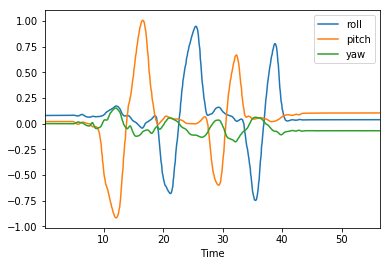

In [8]:
plt.figure()
tcm_raw.plot()

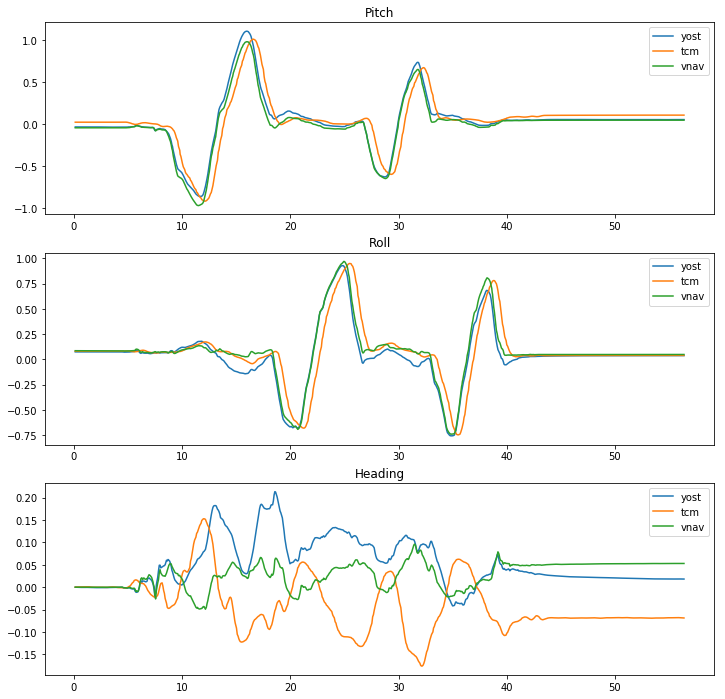

In [9]:
fig,ax = plt.subplots(3,1, figsize=(12,12))

ax[0].plot(yost['pitch'], label='yost')
ax[0].plot(tcm['pitch'], label='tcm')
ax[0].plot(vnav['pitch'], label='vnav')
ax[0].set_title('Pitch')
ax[0].legend()

ax[1].plot(yost['roll'], label='yost')
ax[1].plot(tcm['roll'], label='tcm')
ax[1].plot(vnav['roll'], label='vnav')
ax[1].set_title('Roll')
ax[1].legend()

ax[2].plot(yost['yaw'], label='yost')
ax[2].plot(tcm['yaw'], label='tcm')
ax[2].plot(vnav['yaw'], label='vnav')
ax[2].set_title('Heading')
ax[2].legend()